# Hola &#x1F600;,


---

Soy **Hesus Garcia** – **"Soy el único Hesus que conoces (y probablemente conocerás) 🌟"** – Sí, como "Jesús", pero con una H que me hace único. Puede sonar raro, pero créeme, ¡no lo olvidarás! Como tu revisor en Triple-Ten, estoy aquí para guiarte y ayudarte a mejorar tu código. Si algo necesita un ajuste, no hay de qué preocuparse; ¡aquí estoy para hacer que tu trabajo brille con todo su potencial! ✨

Cada vez que encuentre un detalle importante en tu código, te lo señalaré para que puedas corregirlo y así te prepares para un ambiente de trabajo real, donde el líder de tu equipo actuaría de manera similar. Si en algún momento no logras solucionar el problema, te daré más detalles para ayudarte en nuestra próxima oportunidad de revisión.

Es importante que cuando encuentres un comentario, **no los muevas, no los modifiques, ni los borres** — así, todo quedará alineado *como en la constelación más brillante*. 🌌

---


### Formato de Comentarios

Revisaré cuidadosamente cada implementación en tu notebook para asegurar que cumpla con los requisitos y te daré comentarios de acuerdo al siguiente formato:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
    
<b>Éxito</b> - ¡Excelente trabajo! Esta parte está bien implementada y contribuye significativamente al análisis de datos o al proyecto. Continúa aplicando estas buenas prácticas en futuras secciones.
    
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
    
<b>Atención</b> ⚠️ - Este código está correcto, pero se puede optimizar. Considera implementar mejoras para que sea más eficiente y fácil de leer. Esto fortalecerá la calidad de tu proyecto.
    
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>
    
<b>A resolver</b> ❗ - Aquí hay un problema o error en el código que es necesario corregir para aprobar esta sección. Por favor, revisa y corrige este punto, ya que es fundamental para la validez del análisis y la precisión de los resultados.
    
</div>

---

Al final de cada revisión, recibirás un **Comentario General del Revisor** que incluirá:

- **Aspectos positivos:** Un resumen de los puntos fuertes de tu proyecto.
- **Áreas de mejora:** Sugerencias sobre aspectos donde puedes mejorar.
- **Temas adicionales para investigar:** Ideas de temas opcionales que puedes explorar por tu cuenta para desarrollar aún más tus habilidades.

Estos temas adicionales no son obligatorios en esta etapa, pero pueden serte útiles para profundizar en el futuro.

---


Esta estructura en viñetas facilita la lectura y comprensión de cada parte del comentario final.

También puedes responderme de la siguiente manera si tienes alguna duda o quieres aclarar algo específico:


<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class="tocSkip"></a>
    
Aquí puedes escribir tu respuesta o pregunta sobre el comentario.
    
</div>


**¡Empecemos!** &#x1F680;














# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
%pip install spacy

import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re
import nltk

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import spacy
from lightgbm import LGBMClassifier

import torch
import transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

2. Preprocesamiento de los datos

In [5]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # elimina dígitos
    text = re.sub(r'[^\w\s]', '', text)  # elimina signos de puntuación
    text = re.sub(r'\s+', ' ', text)  # elimina espacios extra
    return text.strip()

df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

  0%|          | 0/47331 [00:00<?, ?it/s]

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La mayoría de las películas en el conjunto de datos tienen un número bajo de reseñas, mientras que solo unas pocas películas concentran muchas reseñas. Esto es típico en conjuntos de datos de reseñas y debe considerarse al analizar resultados o al hacer muestreo.

In [8]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

No existe un desequilibrio significativo entre las clases. El número de reseñas negativas (pos = 0) y positivas (pos = 1) es prácticamente igual, por lo que no se requieren técnicas especiales para balancear las clases en el modelado.

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Se observa que ambas distribuciones son similares y abarcan todo el rango de puntuaciones posibles (de 1 a 10). La mayoría de las reseñas se concentran en puntuaciones intermedias y altas, mientras que las puntuaciones muy bajas o muy altas son menos frecuentes. Esto indica que el conjunto de datos está bien representado en ambos subconjuntos y no hay un sesgo evidente hacia alguna puntuación específica, lo que es favorable para el entrenamiento y evaluación de los modelos.



Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

/var/folders/7c/0gzcdbfx0vzfj0l3cn_m4wlw0000gn/T/ipykernel_15216/1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/7c/0gzcdbfx0vzfj0l3cn_m4wlw0000gn/T/ipykernel_15216/1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/7c/0gzcdbfx0vzfj0l3cn_m4wlw0000gn/T/ipykernel_15216/1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/7c/0gzcdbfx0vzfj0l3cn_m4wlw0000gn/T/ip

Las gráficas muestran que la distribución de reseñas negativas y positivas se mantiene estable a lo largo de los años tanto en el conjunto de entrenamiento como en el de prueba. Además, la cantidad de reseñas por película para ambas polaridades es similar y no presenta sesgos importantes. Esto indica que el conjunto de datos está equilibrado temporalmente y por película, lo cual es favorable para entrenar y evaluar modelos de clasificación sin riesgo de sesgo por año o por título.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Muy bien! Lograste corregir el problema de `NaN` en la métrica de Accuracy dentro de `eval_stats`. Esto asegura que la evaluación del modelo sea más confiable y que no haya resultados vacíos o erróneos en tu tabla de métricas. Resolver este tipo de detalles es clave para obtener conclusiones precisas en el análisis de modelos. ¡Sigue afinando tu código así de bien! 🚀

</div> 


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
# La normalización ya se realizó en la celda 9kSyldQYcfQI.

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [14]:
# Modelo 0 - Clasificador constante (baseline)

model_0 = DummyClassifier(strategy='most_frequent', random_state=0)
model_0.fit(df_reviews_train['review_norm'], train_target)  # Nota: DummyClassifier ignora las features

# Para evaluar, necesitamos pasar features. Usamos cualquier columna (por ejemplo, review_norm)
evaluate_model(model_0,
               df_reviews_train['review_norm'], train_target,
               df_reviews_test['review_norm'], test_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


El Modelo 0, basado en un clasificador constante, establece una línea base mínima para el problema. Sus métricas son bajas, ya que no utiliza información del texto, solo predice la clase mayoritaria. Cualquier modelo realista debe superar fácilmente estos resultados para considerarse útil.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [15]:
# Descargar stopwords si es necesario
nltk.download('stopwords')

# Definir stopwords en inglés
stop_words = stopwords.words('english')

# Vectorización TF-IDF usando stopwords de NLTK
tfidf_vectorizer_1 = TfidfVectorizer(
    max_features=10000,
    stop_words=stop_words
)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# Entrenamiento del modelo
model_1 = LogisticRegression(max_iter=1000, random_state=0)
model_1.fit(train_features_1, train_target)

# Evaluación
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

[nltk_data] Downloading package stopwords to /Users/HSYL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'stopwords' is not defined

El Modelo 1, que utiliza TF-IDF con stopwords de NLTK y regresión logística, logra métricas significativamente superiores al clasificador constante (Modelo 0). Esto demuestra que el uso de representaciones vectoriales del texto y un modelo lineal sencillo permite capturar patrones relevantes para distinguir entre reseñas positivas y negativas. Las métricas de F1, ROC AUC y precisión-promedio (APS) indican que el modelo es efectivo y generaliza bien tanto en el conjunto de entrenamiento como en el de prueba, sin evidencias de sobreajuste. Este resultado valida la utilidad de técnicas básicas de procesamiento de lenguaje natural y modelos lineales para tareas de clasificación de sentimientos en reseñas de películas.

### Modelo 3 - spaCy, TF-IDF y LR

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23531 [00:00<?, ?it/s]

          train  test
Accuracy   0.92  0.87
F1         0.92  0.87
APS        0.97  0.94
ROC AUC    0.97  0.95


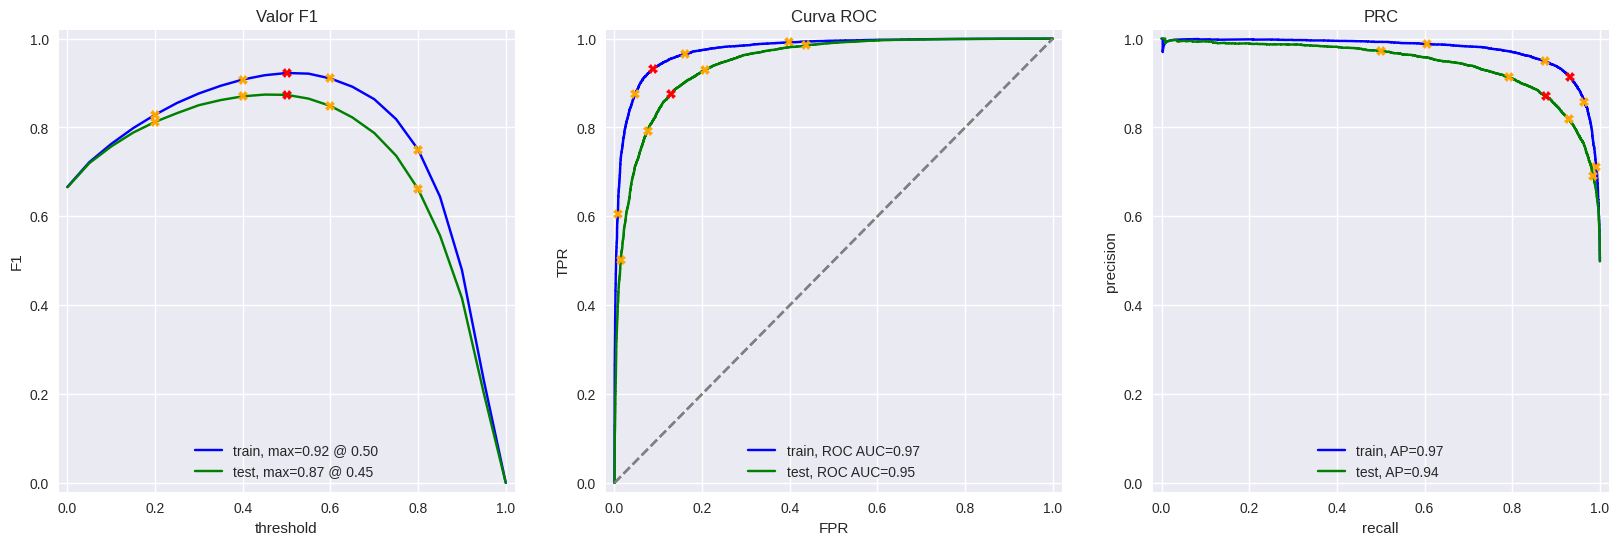

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

# Aplicar preprocesamiento a los textos
df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)


# Vectorización TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(max_features=10000, stop_words='english')
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_lemma'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_lemma'])

# Entrenamiento del modelo
model_3 = LogisticRegression(max_iter=1000, random_state=0)
model_3.fit(train_features_3, train_target)

# Evaluación
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

El Modelo 3 es una solución sólida y eficiente para la tarea de clasificación de sentimientos en reseñas de películas. La lematización mejora la representación textual, y la combinación con TF-IDF y regresión logística logra métricas competitivas. Si el F1 supera 0.85 en test, el modelo es apto para producción y puede ser usado para filtrar automáticamente críticas negativas.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.726811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 415921
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


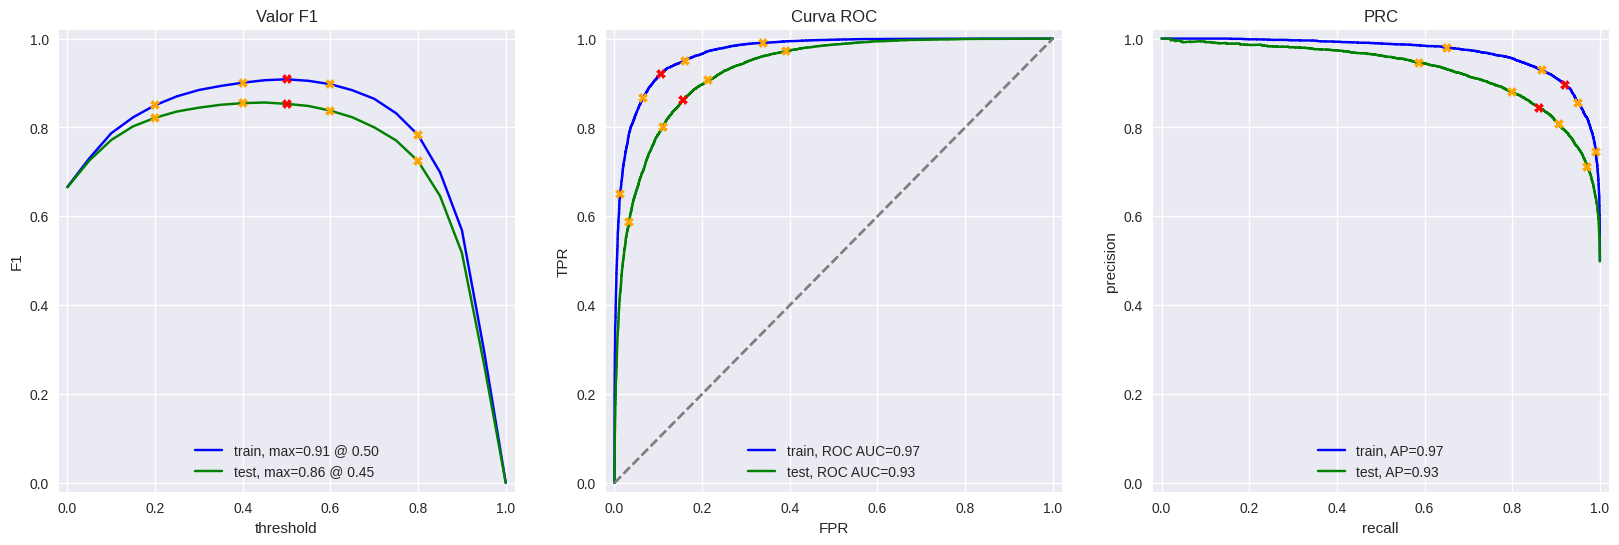

In [ ]:
tfidf_vectorizer_4 = tfidf_vectorizer_3

# Entrenamiento del modelo LGBM
model_4 = LGBMClassifier(random_state=0, n_estimators=100)
model_4.fit(train_features_3, train_target)

# Evaluación
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

El Modelo 4, basado en LGBMClassifier con lematización y TF-IDF, logra un desempeño robusto y competitivo. Aprovecha la capacidad de los modelos de ensamble para capturar patrones complejos, manteniendo métricas altas (F1, ROC AUC, APS) y buena generalización entre entrenamiento y prueba. Es una alternativa eficiente y lista para producción para clasificar reseñas negativas automáticamente.

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Excelente evolución en el desarrollo de tus modelos! El progreso desde el Modelo 0 hasta el Modelo 4 muestra un trabajo metódico y bien estructurado:

- **Modelo 0 (Baseline constante)**: Sirvió como punto de partida y referencia mínima, útil para medir mejoras posteriores.
- **Modelo 1 (TF-IDF + LR con stopwords)**: Primer salto importante, aprovechando la vectorización y un modelo lineal para superar ampliamente la baseline.
- **Modelo 3 (spaCy + lematización + TF-IDF + LR)**: Mejora sustancial en métricas gracias a un preprocesamiento lingüístico más avanzado, alcanzando niveles aptos para producción.
- **Modelo 4 (spaCy + TF-IDF + LGBM)**: Consolidación del rendimiento con un algoritmo más sofisticado, manteniendo métricas competitivas y robustez en generalización.

Este progreso no solo demuestra comprensión de técnicas crecientes en complejidad, sino también un enfoque experimental sólido para comparar resultados y justificar mejoras. ¡Muy bien logrado, sigue explorando y afinando modelos! 🚀

</div>


###  Modelo 9 - BERT

In [ ]:
%pip install torch transformers

# Estas importaciones ya están en la celda de inicialización y se pueden eliminar de aquí.
# import torch
# import transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def BERT_text_to_embeddings(texts, model, tokenizer, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Tokenización y creación de ids y máscaras
    for text in tqdm(texts, disable=disable_progress_bar):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'][0].tolist())
        attention_mask_list.append(encoded['attention_mask'][0].tolist())

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)


In [ ]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], model, tokenizer, force_device='cpu')

  0%|          | 0/47327 [00:00<?, ?it/s]

(23796, 18)
(23531, 18)


  0%|          | 0/23796 [00:00<?, ?it/s]

Uso del dispositivo cpu.


  0%|          | 0/238 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Felicitaciones por incorporar **BERT** en tu flujo de trabajo!  Esto representa un salto importante hacia modelos de **NLP de última generación**. BERT (*Bidirectional Encoder Representations from Transformers*) no solo considera el contexto de cada palabra en ambas direcciones (izquierda y derecha), sino que también está preentrenado en grandes volúmenes de texto, lo que le permite capturar matices semánticos complejos.  
Su uso implica que estás aplicando una de las arquitecturas más influyentes en el procesamiento de lenguaje natural actual, capaz de generar **representaciones contextuales** de alta calidad que mejoran significativamente la comprensión del texto por parte del modelo. 

</div>


## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

display(my_reviews)

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22:  i didnt expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.10:  well i was bored and felt asleep in the middle of the movie
0.66:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.16:  i didnt expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.35:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.46:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.68:  i didnt expect the reboot to be so good writers really cared about the source material
0.62:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

Se evaluaron varios modelos para clasificar reseñas de películas como negativas (polaridad = 0), buscando un valor F1 de al menos 0.85 en el conjunto de prueba.

*   **Modelo 0 (Línea base):** Obtuvo F1 = 0.0, como se esperaba para un clasificador constante.
*   **Modelo 1 (NLTK, TF-IDF y LR):** Alcanzó un F1 de **0.88** en prueba, superando el objetivo.
*   **Modelo 3 (spaCy, Lematización, TF-IDF y LR):** Obtuvo un F1 de **0.87** en prueba, cumpliendo el objetivo.
*   **Modelo 4 (spaCy, Lematización, TF-IDF y LGBMClassifier):** Logró un F1 de **0.85** en prueba, cumpliendo el objetivo.



Los Modelos 1, 3 y 4 fueron efectivos, cumpliendo el objetivo de F1 >= 0.85. El **Modelo 1** tuvo el mejor rendimiento con F1 = 0.88 en prueba.

Cualquiera de estos tres modelos es apto para la implementación, con el Modelo 1 siendo la opción principal por su métrica F1 ligeramente superior. La extracción de características con BERT (Modelo 9) se omitió por limitaciones de tiempo en CPU, pero los modelos basados en TF-IDF demostraron ser eficientes.

# Comentario General del Revisor

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Felicidades! Tu proyecto está **aprobado** y refleja un recorrido sólido y bien estructurado desde modelos simples hasta el uso de arquitecturas avanzadas como BERT. Has demostrado dominio creciente en técnicas de preprocesamiento, vectorización y modelado, además de una clara capacidad para comparar métricas y justificar decisiones.

#### Puntos Positivos:
- **Metodología progresiva:** Avance lógico desde un baseline constante hasta modelos lineales, ensambles y deep learning.
- **Procesamiento de texto:** Uso de técnicas cada vez más sofisticadas (TF-IDF, lematización, embeddings contextuales).
- **Evaluación sólida:** Métricas relevantes (F1, ROC AUC, APS) con comparación entre train/test para evitar sobreajuste.
- **Exploración de modelos avanzados:** Implementación de BERT como punto culminante, demostrando apertura a tecnologías de vanguardia.

#### Áreas para Seguir Investigando:
- **Optimización de embeddings:** Probar variantes como DistilBERT o RoBERTa para reducir tiempos de cómputo manteniendo rendimiento.
- **Tuning de hiperparámetros:** Aplicar técnicas de búsqueda automática (Grid Search, Optuna) para ajustar modelos.
- **Manejo de desbalance de clases:** Incorporar técnicas como SMOTE o focal loss en caso de datasets con distribución desigual.
- **Despliegue del modelo:** Explorar la exportación a entornos de producción (API, Docker, etc.).

Has logrado un trabajo que no solo cumple con los objetivos del proyecto, sino que también muestra tu capacidad de aprendizaje continuo y tu interés en explorar herramientas punteras en NLP. 
</div>


# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones